In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving modis_flood_features_cleaned_v1.1.csv to modis_flood_features_cleaned_v1.1.csv


In [ ]:
#Load Dataset
import io
df = pd.read_csv('modis_flood_features_cleaned_v1.1.csv', parse_dates=['date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472156 entries, 0 to 1472155
Data columns (total 16 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1472156 non-null  datetime64[ns]
 1   lon             1472156 non-null  float64       
 2   lat             1472156 non-null  float64       
 3   flooded         1472156 non-null  float64       
 4   jrc_perm_water  1472156 non-null  float64       
 5   precip_1d       1472156 non-null  float64       
 6   precip_3d       1472156 non-null  float64       
 7   NDVI            1472156 non-null  float64       
 8   NDWI            1472156 non-null  float64       
 9   landcover       1472156 non-null  float64       
 10  elevation       1472156 non-null  float64       
 11  slope           1472156 non-null  float64       
 12  aspect          1472156 non-null  float64       
 13  upstream_area   1472156 non-null  float64       
 14  TWI             14

In [ ]:
#Preprocessing
X = df.drop(columns=['date', 'target', 'jrc_perm_water','flooded'])
y = df['target']

In [ ]:
#Normalisasi
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

=== RF Baseline ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    284488
           1       0.85      0.63      0.72      9944

    accuracy                           0.98    294432
   macro avg       0.92      0.81      0.86    294432
weighted avg       0.98      0.98      0.98    294432

ROC AUC: 0.989362757692339


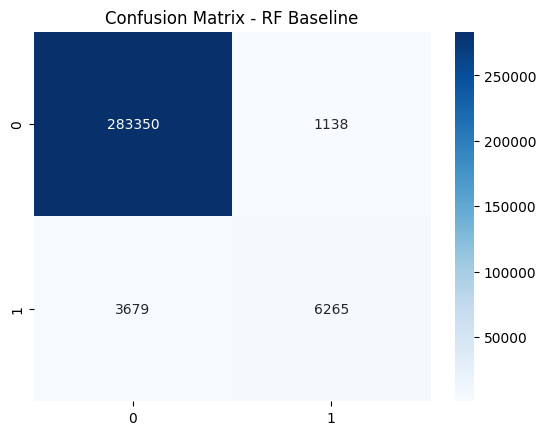

In [ ]:
#RF baseline
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)
y_proba_baseline = rf_baseline.predict_proba(X_test)[:, 1]

print("=== RF Baseline ===")
print(classification_report(y_test, y_pred_baseline))
print("ROC AUC:", roc_auc_score(y_test, y_proba_baseline))

sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - RF Baseline")
plt.show()

=== RF + SMOTE ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    284488
           1       0.70      0.78      0.74      9944

    accuracy                           0.98    294432
   macro avg       0.85      0.88      0.86    294432
weighted avg       0.98      0.98      0.98    294432

ROC AUC: 0.9892254110858609


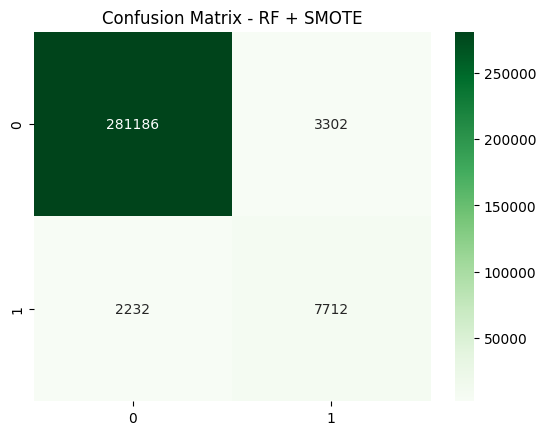

In [ ]:
#RF + SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_resampled, y_resampled)

y_pred_smote = rf_smote.predict(X_test)
y_proba_smote = rf_smote.predict_proba(X_test)[:, 1]

print("=== RF + SMOTE ===")
print(classification_report(y_test, y_pred_smote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_smote))

sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - RF + SMOTE")
plt.show()

In [ ]:
#RF + Feature Selection
importances = rf_baseline.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

top_n = 10
top_features = feat_imp_df['Feature'].head(top_n).tolist()

print(f"Top {top_n} features:\n", top_features)

rf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
rf_fs.fit(X_train[top_features], y_train)

Top 10 features:
 ['NDWI', 'lat', 'elevation', 'NDVI', 'lon', 'precip_3d', 'slope', 'precip_1d', 'TWI', 'upstream_area']


RandomForestClassifier(random_state=42)

=== RF + Feature Selection ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    284488
           1       0.83      0.63      0.72      9944

    accuracy                           0.98    294432
   macro avg       0.91      0.81      0.86    294432
weighted avg       0.98      0.98      0.98    294432

ROC AUC: 0.9889479185997759


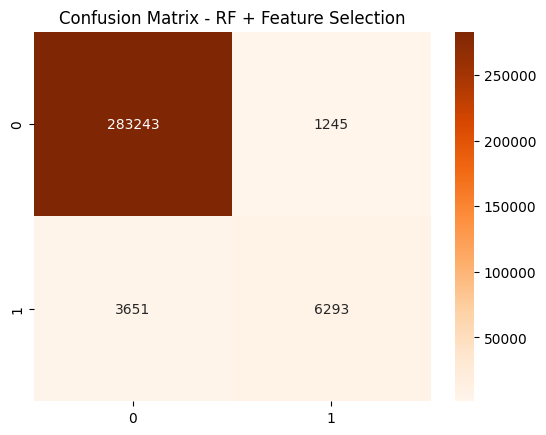

In [ ]:
#Evaluasi RF + Feature Selection
y_pred_fs = rf_fs.predict(X_test[top_features])
y_proba_fs = rf_fs.predict_proba(X_test[top_features])[:, 1]

print("=== RF + Feature Selection ===")
print(classification_report(y_test, y_pred_fs))
print("ROC AUC:", roc_auc_score(y_test, y_proba_fs))

sns.heatmap(confusion_matrix(y_test, y_pred_fs), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - RF + Feature Selection")
plt.show()

In [ ]:
#RF + Undersampling
from imblearn.under_sampling import RandomUnderSampler

# ----- Eksperimen 3: RF + Undersampling -----
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)

rf_under = RandomForestClassifier(n_estimators=100, random_state=42)
rf_under.fit(X_under, y_under)


RandomForestClassifier(random_state=42)

=== RF + Undersampling ===
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    284488
           1       0.33      0.97      0.49      9944

    accuracy                           0.93    294432
   macro avg       0.67      0.95      0.73    294432
weighted avg       0.98      0.93      0.95    294432

ROC AUC: 0.9860721145668068


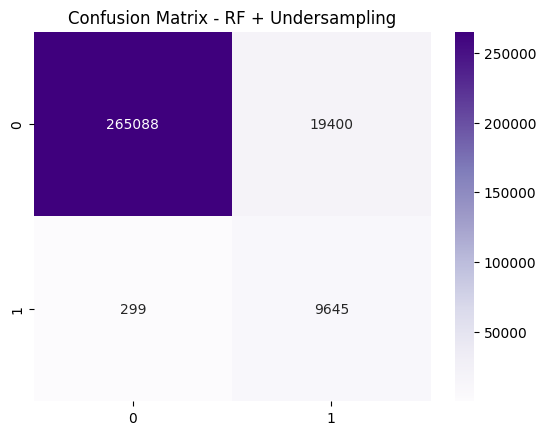

In [ ]:
#Evaluasi RF + Undersampling
y_pred_under = rf_under.predict(X_test)
y_proba_under = rf_under.predict_proba(X_test)[:, 1]

print("=== RF + Undersampling ===")
print(classification_report(y_test, y_pred_under))
print("ROC AUC:", roc_auc_score(y_test, y_proba_under))

sns.heatmap(confusion_matrix(y_test, y_pred_under), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - RF + Undersampling")
plt.show()